<a href="https://colab.research.google.com/github/mknomics/soda/blob/main/Elasticity_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/i-HnvsehuSw" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')


In [31]:

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/BHpqF06i2ZI" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')


# SODA DATA
This dataset contains product level montly data for multiple stores and products within Greece.  


**IMPORTANT DISCLAIMER**  I use this dataset to do a naive estimation of various demand equations BUT doing so is hazardously wrong in practice.  Why? The Data points in this set are the result of an interaction of BOTH supply AND demand.  Our interpretation of Demand is "willingness-to-pay".  A true demand schedule is more properly represented in the [Google Sheet](https://docs.google.com/spreadsheets/d/1w5R60JGle5JAWz_wFuQ7dutR948jm60gSvcUTqK2UUI/edit?usp=sharing) that we completed in class.  

A more robust estimation would use causal analysis and other experimental methods not covered here. 

df_city[METRIC][CITY][BRAND][CONTAINER]

**METRIC** is in [mean_q, mean_p]

**CITY** is in ['Athens', 'Irakleion', 'Larisa', 'Patra', 'Thessaloniki']

**BRAND** is in ['adult-cola', 'gazoza', 'kinder-cola', 'lemon-boost',  'orange-power']

**CONTAINER** is in ['plastic', 'can', 'glass']

## Import Packages


In [32]:
#@title 
import pandas as pd  #pandas is good for data manipulation.  I rename it here as "pd" to make it easier to call in the script below.  I could rename it anything I want but "pd" is standard
import matplotlib.pyplot as plt #matplotlib is a good package for graphing.  Again, I rename it plt to make coding more simple
import numpy as np #numpy is a good package for doing calculations
from sklearn.linear_model import LinearRegression  #sklearn is a package that is good at estimation.  Tons of models are available and here I import LinearRegression because that's all I need
from IPython.core.display import HTML



## Get Some Data

In [33]:
#@title
#Import a csv file from a target url:  What is a csv file?  Go to the url below to see the raw data.  columns are separated by a "," and the last column lacks a ","
data_url='https://raw.githubusercontent.com/mknomics/soda/main/soda.csv' # I define a string variable using apostrophe ' but I could ahve also used quotes " ".  I just cannot mix apostophe and quotes in the same line
df = pd.read_csv(data_url) # This line creates a pandas DataFrame that I defined as "df".  I could have called it anything I want

# Set my date objects.  This must be done so that 'date' is recognized as a date and not just a random string variable
df['date']=pd.to_datetime(df['date']) #make date a datetime object
df['year']=pd.DatetimeIndex(df['date']).year # I define a variable 'year' using the DatetimeIndex method
df['month']=pd.DatetimeIndex(df['date']).month # similarly I repeat and define 'month'

#@title
#Step 1: use groupby method and define a new dataframe for each of the metrics that we are interested in
df_mean_Q = df.groupby(['brand','container','city','date'])['quantity'].mean().reset_index()# I reset the index for each new data set.  Don't worry if the indexing is confusing since it isn't the main point here
df_mean_P = df.groupby(['brand','container','city','date'])['price'].mean().reset_index()
# Step 2: the data frames from Step #1 can be merged by their unique rows.  Rows are unique by city x brand x container x date
df_city = pd.merge(df_mean_Q, df_mean_P) # merges df_total_Q dataframe with df_mean_P dataframe based on their unique rows

# Now let's rename the price and quantity column so we don't get confused later about what we are looking at
df_city.rename(columns={'quantity': 'mean_q', 'price': 'mean_p'},inplace=True) # I 

# we lost our columns df['year'] and df['month'] so lets add these back
df_city['year']=pd.DatetimeIndex(df_city['date']).year # I define a variable 'year' using the DatetimeIndex method
df_city['month']=pd.DatetimeIndex(df_city['date']).month # similarly I repeat and define 'month'about what we are looking at
df_city.rename(columns={'quantity': 'mean_q', 'price': 'mean_p'},inplace=True) 

df_city = df_city.pivot(index='date', columns=['city','brand','container'], values=['mean_q','mean_p'])


In [34]:
#@title
df.head()

,id,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity,year,month
0,1222,2013-02-28,Athens,37.96245,23.68708,671022,shop_3,adult-cola,plastic,1.5lt,2.46,10709,2013,2
1,1256,2013-02-28,Athens,37.97945,23.71622,671022,shop_1,adult-cola,plastic,1.5lt,1.91,12703,2013,2
2,2325,2014-02-28,Athens,37.97945,23.71622,668203,shop_1,adult-cola,plastic,1.5lt,3.99,3642,2014,2
3,2333,2014-02-28,Athens,37.96245,23.68708,668203,shop_3,adult-cola,plastic,1.5lt,2.82,9282,2014,2
4,3334,2015-02-28,Athens,37.97945,23.71622,667237,shop_1,adult-cola,plastic,1.5lt,1.29,15782,2015,2


### Interpret dataset
Each line represents the montly sales volume and average price for a specific brand/bottle type of cola that was sold in a specific store within Greece 




### Descriptive Statistics


In [35]:
#@title
print("There are " + str(df[['id']].nunique()[0]) + " unique shops in this dataset")
df.describe()

There are 7560 unique shops in this dataset


,id,lat,long,pop,price,quantity,year,month
count,7560.00000,7501.000000,7501.000000,7560.000000,7560.000000,7560.000000,7560.000000,7560.000000
mean,3779.50000,38.300808,23.270191,355174.095238,1.196049,29421.715212,2015.000000,6.500000
std,2182.52835,1.650503,1.087175,232441.012350,0.816838,17665.033867,2.000132,3.452281
min,0.00000,35.327870,21.734440,134219.000000,0.110000,2953.000000,2012.000000,1.000000
25%,1889.75000,37.962450,22.417610,141732.000000,0.620000,16572.750000,2013.000000,3.750000
50%,3779.50000,38.244440,22.930860,257501.500000,0.930000,25312.000000,2015.000000,6.500000
75%,5669.25000,39.636890,23.716220,665102.000000,1.510000,37751.500000,2017.000000,9.250000
max,7559.00000,40.643610,25.143410,672130.000000,4.790000,145287.000000,2018.000000,12.000000


In [36]:
#@title
def Athens(Q_brand=True, Q_container=True, P_brand=True, P_container=True):

 # define independent variable X
  X = df_city['mean_q']['Athens'][Q_brand][Q_container].values.reshape(-1,1) #convert to numpy array using "values"
  # define dependent variable Y
  Y = df_city['mean_p']['Athens'][P_brand][P_container].values.reshape(-1,1)

  linear_regression = LinearRegression() # Create a linear_regression object
  linear_regression.fit(X , Y)  # Fit the model
  Y_pred = linear_regression.predict(X)  # Fits the Data Points "X" with the parameters from the Fit step to form a prediction

  plt.scatter(X, Y)
  plt.plot(X, Y_pred, color='red')


  #plt.scatter( df_city['mean_p']['Athens'][P_brand][P_container], df_city['mean_q']['Athens'][Q_brand][Q_container])
  #add title and axis labels
  plt.title('Price and Quantity')
  plt.xlabel('Quantity '+ " " + Q_brand+ " " + Q_container)
  plt.ylabel('Price' +" " + P_brand + " " + P_container)

  return plt.show()




In [37]:
#@title
import numpy as np
from sklearn.linear_model import LinearRegression

def own_price(Q_brand=True, Q_container=True, PricePoint=True):

  Athens(Q_brand=Q_brand,Q_container=Q_container,P_brand=Q_brand,P_container=Q_container)
  Qx = df_city['mean_q']['Athens'][Q_brand][Q_container].values.reshape(-1,1) #convert to numpy array using "values"
  # define dependent variable Y
  Px = df_city['mean_p']['Athens'][Q_brand][Q_container].values.reshape(-1,1)

  reg = LinearRegression().fit(Px, Qx)
  reg.score(Px, Qx)
  P=PricePoint
  Q_hat=reg.predict(np.array(P).reshape(-1, 1))
  
  return print('the price elaticity is '+ str(reg.coef_ * (P/Q_hat)))



In [38]:
#@title
import numpy as np
from sklearn.linear_model import LinearRegression


def cross_price(Q_brand=True, Q_container=True, P_brand=True, P_container=True, PricePoint=True):

  Athens(Q_brand=Q_brand,Q_container=Q_container,P_brand=P_brand,P_container=P_container)
  Qx = df_city['mean_q']['Athens'][Q_brand][Q_container].values.reshape(-1,1) #convert to numpy array using "values"
  # define dependent variable Y
  Px1 = df_city['mean_p']['Athens'][Q_brand][Q_container].values.reshape(-1,1)
  Px2 = df_city['mean_p']['Athens'][P_brand][P_container].values.reshape(-1,1)
  Px = np.concatenate((Px1, Px2), axis=1)

  mPx1 = np.mean(Px1)
  

  #mod = sm.OLS(Qx,Px)
  #fii = mod.fit()
  #p_values = fii.summary2().tables[1]['P>|t|']

  reg = LinearRegression().fit(Px, Qx)
  reg.score(Px, Qx)
  P=np.array([[mPx1, PricePoint]])
  Q_hat=reg.predict(P)
  
  return print('the cross-price-elasticity for ' + P_brand + ' is =' + str((reg.coef_ *(PricePoint/Q_hat))[0][1]))




In [39]:
#@title
brands=['adult-cola', 'gazoza', 'kinder-cola', 'lemon-boost', 'orange-power']

def cross_price_plot(brand=True, container=True):
  for i in brands:
    if i !=brand:
      PricePoint=np.mean(df_city['mean_p']['Athens'][i][container])
      cross_price(Q_brand=brand, Q_container=container, P_brand=i, P_container=container, PricePoint=PricePoint)

# Skip to HERE 


**Complete the following steps**


1.   Go to the Colab toolbar at the top of the page and click:  
2.   Runtime --> Run Before


Now you can **either** 

proceed to the Code-Playground below, where you can write your own functions

**or**

proceed to the Functions, Methods and Theories if you need to understand more about how to use the functions in this notebook

In [40]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/ZajwdmX_S50" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

# Code Playground
Enter functions here or create your own code blocks anywhere else in the notebook.  Below is a short video about how to get started with Google Colab in case you are lost

In [41]:
# Your code here

In [42]:
# Your code here

# Functions, Methods and Theories 


###**Price Elasticity of Demand Function**

```
own_price(Q_brand=True, Q_container=True, PricePoint=True)

```
Q_brand is one of ['adult-cola', 'gazoza', 'kinder-cola', 'lemon-boost', 'orange-power']

Q_container is one of ['plastic', 'can', 'glass']

The point elasticity is the number located at the bottom of the graph.*italicized text*

Computes the price elasticity of demand for a brand, container type at a given Price Point.  You can enter different price points and evaluate how the elasticity of demand changes.  

**NOTE** Be careful to enter prices that are reasonable (within the min and max of observable prices), but feel free to enter extreme values and see how the model behaves


```

#### Example

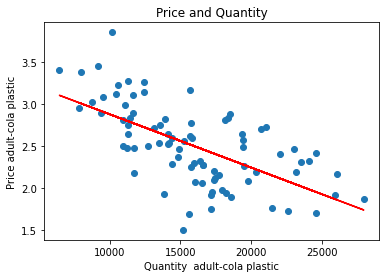

the price elaticity is [[-0.65615218]]


In [43]:
own_price(Q_brand='adult-cola', Q_container='plastic', PricePoint=2)


### Cross-Price Elasticity of Demand

**Cross Price Elasticity of Demand Function**

Computes the cross price elasticity of demand for a brand, container type at a given Price Point.  You can enter different price points and evaluate how the elasticity of demand changes.  


```
cross_price(Q_brand=True, Q_container=True, P_brand=True, P_container=True, PricePoint=True)
```

Q_brand and P_brand are one of ['adult-cola', 'gazoza', 'kinder-cola', 'lemon-boost', 'orange-power']


Q_container and P_brand are one of ['plastic', 'can', 'glass']

$\frac{\% \Delta Q_x}{\% \Delta P_y}$ is the percentage change in the Quantity of good X induced by a percentage change in the Price of good Y.  

**Note:** 2 goods need to be defined.  Goods in this dataset are defined by brand and container.  Thus the P_brand and P_container define the product on the denominator, while Q_brand and Q_container define the product on the numerator of $\frac{\% \Delta Q_x}{\% \Delta P_y}$ 


**NOTE** Be careful to enter prices that are reasonable (within the min and max of observable prices), but feel free to enter extreme values and see how the model behaves

#### Example

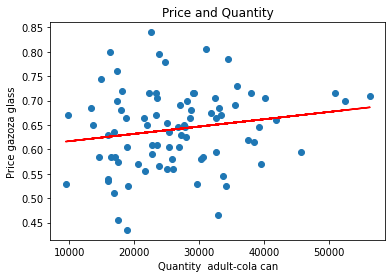

the cross-price-elasticity for gazoza is =0.3161239529791243


In [44]:
cross_price(Q_brand='adult-cola',Q_container='can',P_brand='gazoza',P_container='glass',PricePoint=0.7)

### Cross-Price Plot Function

**Cross Price Plot**

Calculates and plots multiple cross-price elasticities for a given brand and container.

```
cross_price_plot(brand=True, container=True)
```


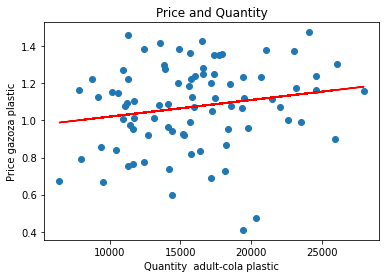

the cross-price-elasticity for gazoza is =0.17819199077580666


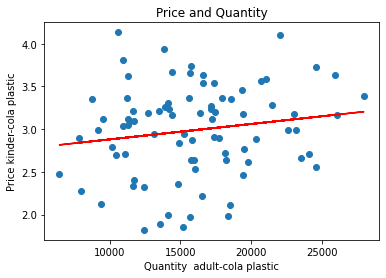

the cross-price-elasticity for kinder-cola is =0.0909081976134235


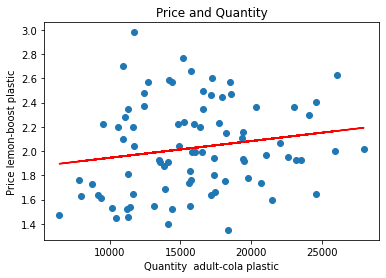

the cross-price-elasticity for lemon-boost is =0.04662474046011142


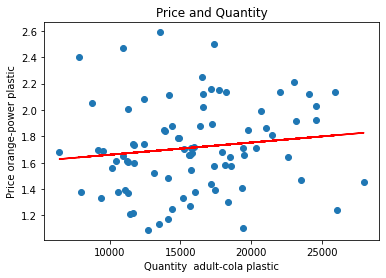

the cross-price-elasticity for orange-power is =0.05720594606496297


In [45]:
cross_price_plot(brand='adult-cola', container='plastic')

# Interpreting Results
Elasticity is defined in terms of percentage change and this changes depending on where we are along the demand curve 

Your textbook gives you a formula for calculating percentage change using the mid-point-method.  I will use a different method, which is based on Linear Regression.  This method allows us to evaluate price elasticity for a specific price point on the demand curve.  

A high level overview of regression methods is located in a separate section above.  

The key point to remember is that we still have only correlation, NOT causation.  Causation is what we would like to have.  In words, we would like to know the percentage change in quanitity demand that results from a percentage change in price.  HOWEVER, our data is from market outcomes (prices and quanitities) that are influenced by BOTH supply AND demand.  Thus our data is NOT a pure relationship between price and quanitity.  We need more advanced statistics to get a causal relationship. 

#### Evaluating impact of price changes on Revenues 
Should a price be increased or decreased?  If we are only concerned about the impact on revenues then elasticity is the metric that we want to focus on.

**Relevant Function**

```
own_price(Q_brand=True, Q_container=True, PricePoint=True)

```

In [46]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/GIPX-bnZ6Ao?start=562" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

#### Application:  Revenue Canibalism 
Consider that if two goods, within a firm's product basket, are substitutes, then a promoting one product with a price decrease can canibalize the sale of another product in your brand, thus reducing or even having a negative impact on your overall revenues.  

Consider Total Revenue from two goods X and Y, so that total revenue $R$ is composed of revenue from good X, $R_x$, and revenue from good Y, $R_y$
$$R = R_x + R_y$$

Now consider the managerial question:  Should I drop prices to promote good X?  We first need to ask, "what is the revenue impact on good X?"  Consider the elasticity of good X for this answer $\frac{\% \Delta Q_x}{\% \Delta P_x}$.  Secondly, we also need to consider what impact a price change on x will have on the revenue of good Y.  The price of good Y is not changing.  The only potential change in revenue comes from the changing Quantity of Y, which might change either up or down depending on the cross-price-elasticity: $\frac{\% \Delta Q_y}{\% \Delta P_x}$


### Evaluating Competition
We can use an analysis of cross-price-elasticity to estimate which brands are in competition with one another, which are not and the degree of substitution or complementarity. 

Goods that are stronger substitutes can be considered to be in greater competition with one another.  We can evaluate the degree of substitution by comparing relevant cross-price-elasticities of different goods. 

**Think about it**  If $\frac{\% \Delta Q_y}{\% \Delta P_x}$ is high then does this imply that $\frac{\% \Delta Q_x}{\% \Delta P_y}$ is also high?

Let the data speak on this point and see if you can think of a way to make sense of the data patterns that you find.

# Extra Stuff - Not Required

In [47]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/AzjHTYT8nyU" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

## Regression Methods of Estimating Elasticity
This section is optional but may help you to understand what is going on under the hood

#### What is the best fit line that can possibly be made given the data?  

# $Y = \beta_x X + \beta_0 + \epsilon$
Think $Y=mX+b$ where $m=\beta_x$ and $b=\beta_0$ and $\epsilon$ is an error term

#### If the data is given then a line is defined by the coefficients $\beta_x , \beta_0$

#### Find the "best" values of $\beta_x , \beta_0$.  where "best" minimizes statistical error $\epsilon$

How can we sum up all errors?  Some are positive and some are negative?  Solution: define the error as the squared error loss $$\sum\epsilon^2$$ 

# Own Price-Elasticity of Demand
# $Q_x = \beta_0 + \beta_x P_x + \epsilon$
where: 

*   $Q_x$ is the quantity of good X
*   $P_x$ is the price of good X
*   $P_y$ is the price of good Y

The Price-Elasticity of Demand is given by:

$\frac{\Delta Q_x}{\Delta P_x} \frac{P_x}{Q_x} = \beta_x \frac{P_x}{Q_x}$

# Cross-Price-Elasticity

# $Q_x = \beta_0 + \beta_x P_x + \beta_y P_y + \epsilon$
where: 


*   $Q_x$ is the quantity of good X
*   $P_x$ is the price of good X
*   $P_y$ is the price of good Y

